# 0. Instalacion de utilitarios Pyspark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/SparkR_2.4.4.tar.gz
!ls

drive				 spark-2.4.4-bin-hadoop2.7.tgz.1
sample_data			 spark-2.4.4-bin-hadoop2.7.tgz.2
spark-2.3.4-bin-hadoop2.7	 SparkR
spark-2.3.4-bin-hadoop2.7.tgz	 SparkR_2.4.4.tar.gz
spark-2.3.4-bin-hadoop2.7.tgz.1  SparkR_2.4.4.tar.gz.1
spark-2.3.4-bin-hadoop2.7.tgz.2  SparkR_2.4.4.tar.gz.2
spark-2.4.4-bin-hadoop2.7	 SparkR_2.4.4.tar.gz.3
spark-2.4.4-bin-hadoop2.7.tgz	 spark-warehouse


In [ ]:
!tar xf SparkR_2.4.4.tar.gz

In [ ]:
!pip install -q findspark

In [ ]:
pwd

'/content'

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.master("victor").getOrCreate()
sc = SparkContext.getOrCreate()

Exception: ignored

# 1. Lectura del origen datos

In [ ]:
# Lectura desde un archivo fisico
#from google.colab import files
#uploaded = files.upload()

In [ ]:

# Conexion al drive
#---------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls "/content/drive/My Drive/PySpark Machine Learning en plataforma Big Data/Training R ML en Casos de Negocios/8_Recomendacion_comercio"

'Caso de recomendacion tipo rappi.pptx'
 Comercio_tipo_rappi.csv
 Comercio_tipo_rappi.gsheet
'PySpark tutorial – a case study using Random Forest on unbalanced dataset – Weimin Wang.url'
'Solucion_CASO_DELIVERY_MEXICO (1).ipynb'


#2.  Cargando los datos en formato Spark

In [ ]:
DS_peliculas_rating = spark.read.csv(
    '/content/drive/My Drive/PySpark Machine Learning en plataforma Big Data/Training R ML en Casos de Negocios/8_Recomendacion_comercio/Comercio_tipo_rappi.csv', 
    sep=';',
    header=True, 
    inferSchema=True
)

DS_peliculas_rating.printSchema()

root
 |-- userID: string (nullable = true)
 |-- userID_cod: integer (nullable = true)
 |-- placeID: integer (nullable = true)
 |-- Nombre_comerce: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- food_rating: integer (nullable = true)
 |-- service_rating: integer (nullable = true)
 |-- rating_total: integer (nullable = true)



In [ ]:
# Dimensiona de base
print(
    DS_peliculas_rating.count(),
    len(DS_peliculas_rating.columns)
)

50766 9


In [ ]:
# 2.2 Revisiones  
DS_peliculas_rating.show(5)

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+
| U1077|         1| 135085|Tortas Locas Hipo...|San Luis Potosi|     2|          2|             2|           6|
| U1077|         1| 135038|Restaurant la Cha...|San Luis Potosi|     2|          2|             1|           5|
| U1077|         1| 132825|     puesto de tacos|         s.l.p.|     2|          2|             2|           6|
| U1077|         1| 135060|Restaurante Maris...|San Luis Potosi|     1|          2|             2|           5|
| U1068|         2| 135104|                vips|              0|     1|          1|             2|           4|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------

In [ ]:
from pyspark.sql.functions import udf
from slugify import slugify

@udf('string')
def apply_slug(_val):
  return slugify(str(_val)).replace('-', '')

DS_peliculas_rating.withColumn(
    'Distritoa', apply_slug(DS_peliculas_rating.Distrito)
).show()

Py4JJavaError: ignored

In [ ]:
DS_peliculas_rating.show(5)

Py4JJavaError: ignored

In [ ]:
list(DS_peliculas_rating.select('Distrito').toPandas()['Distrito'].unique())

Py4JError: ignored

In [ ]:
# 2.3 Validacion de carga del total de registros
print(DS_peliculas_rating.count())

50766


In [ ]:
# 2.4 Exploracion inicial
DS_peliculas_rating.describe().show()

+-------+------+------------------+------------------+--------------------+---------+------------------+------------------+------------------+-----------------+
|summary|userID|        userID_cod|           placeID|      Nombre_comerce| Distrito|            rating|       food_rating|    service_rating|     rating_total|
+-------+------+------------------+------------------+--------------------+---------+------------------+------------------+------------------+-----------------+
|  count| 50766|             50766|             50766|               50766|    50766|             50766|             50766|             50766|            50766|
|   mean|  null| 67.34026710790687|  134254.559390143|                null|      0.0|1.2218216916834101| 1.244277666154513| 1.109856990899421|3.575956348737344|
| stddev|  null|32.640689951647815|1079.9216692471784|                null|      0.0|0.7706200957794772|0.7863420037824467|0.7915679876580894|2.083855254035862|
|    min| U1001|                 1

In [ ]:
# 2.5 Los clientes que más vistaron la plataforma de videos
DS_peliculas_rating.groupBy('userId').count().orderBy('count',ascending=False).show(10,False)

+------+-----+
|userId|count|
+------+-----+
|U1106 |1198 |
|U1071 |949  |
|U1024 |933  |
|U1016 |897  |
|U1036 |876  |
|U1104 |868  |
|U1009 |759  |
|U1037 |755  |
|U1084 |730  |
|U1132 |730  |
+------+-----+
only showing top 10 rows



In [ ]:
# 2.6  Las clientes que menos vieron las peliculas
DS_peliculas_rating.groupBy('userId').count().orderBy('count',ascending=True).show(10,False)

+------+-----+
|userId|count|
+------+-----+
|U1011 |57   |
|U1039 |57   |
|U1129 |76   |
|U1130 |76   |
|U1065 |95   |
|U1043 |95   |
|U1138 |114  |
|U1102 |114  |
|U1077 |117  |
|U1131 |120  |
+------+-----+
only showing top 10 rows



In [ ]:
# 2.7  Las peliculas con mayor numero de visualizaciones
DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=False).show(10,False)

+----------------------------------+-----+
|Nombre_comerce                    |count|
+----------------------------------+-----+
|Tortas Locas Hipocampo            |1641 |
|Cafeteria y Restaurant El Pacifico|1466 |
|puesto de tacos                   |1387 |
|La Cantina Restaurante            |1202 |
|Restaurant la Chalita             |1200 |
|Gorditas Doa Gloria               |1176 |
|Restaurante Marisco Sam           |1017 |
|Restaurant Oriental Express       |955  |
|Restaurante El Cielo Potosino     |945  |
|Luna Cafe                         |836  |
+----------------------------------+-----+
only showing top 10 rows



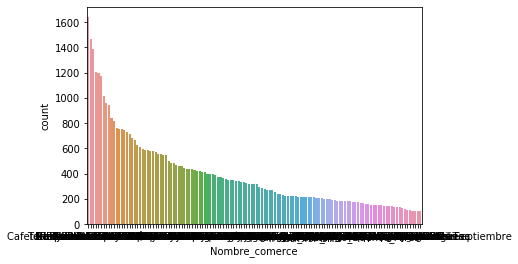

In [ ]:
#Graficas
res= DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=False)
red=res.toPandas()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ax=sns.barplot(x="Nombre_comerce", y="count", data=red)



In [ ]:
# Peliculas con menos numero de visualizaciones 
DS_peliculas_rating.groupBy('Nombre_comerce').count().orderBy('count',ascending=True).show(10,False)

+-------------------------------------+-----+
|Nombre_comerce                       |count|
+-------------------------------------+-----+
|emilianos                            |99   |
|Carnitas Mata  Calle 16 de Septiembre|100  |
|cafe ambar                           |100  |
|la perica hamburguesa                |102  |
|tortas hawai                         |109  |
|puesto de gorditas                   |109  |
|tacos los volcanes                   |118  |
|churchs                              |126  |
|TACOS EL GUERO                       |133  |
|Arrachela Grill                      |135  |
+-------------------------------------+-----+
only showing top 10 rows



In [ ]:
# Peliculas con menos numero de visualizaciones 
DS_peliculas_rating.groupBy('Nombre_comerce','Distrito').count().orderBy('count',ascending=False).show(10,False)

+----------------------------------+---------------+-----+
|Nombre_comerce                    |Distrito       |count|
+----------------------------------+---------------+-----+
|Tortas Locas Hipocampo            |San Luis Potosi|1641 |
|Cafeteria y Restaurant El Pacifico|San Luis Potosi|1466 |
|puesto de tacos                   |s.l.p.         |1387 |
|La Cantina Restaurante            |San Luis Potosi|1202 |
|Restaurant la Chalita             |San Luis Potosi|1200 |
|Gorditas Doa Gloria               |san luis potosi|1176 |
|Restaurante Marisco Sam           |San Luis Potosi|1017 |
|Restaurant Oriental Express       |San Luis Potosi|955  |
|Restaurante El Cielo Potosino     |San Luis Potosi|945  |
|Luna Cafe                         |San Luis Potosi|836  |
+----------------------------------+---------------+-----+
only showing top 10 rows



In [ ]:
# Que clientes consumen mas en cierto establecimiento
DS_peliculas_rating.filter(DS_peliculas_rating['Nombre_comerce']=='Luna Cafe').groupby('userID').count().orderBy('count',ascending=False).show(10,False)

+------+-----+
|userID|count|
+------+-----+
|U1049 |73   |
|U1005 |73   |
|U1024 |73   |
|U1104 |69   |
|U1045 |69   |
|U1054 |61   |
|U1075 |49   |
|U1126 |41   |
|U1106 |41   |
|U1086 |40   |
+------+-----+
only showing top 10 rows



# 3. Feature Engineering: Tansforma pelicula a numero



In [ ]:
# Importando el codifocador
from pyspark.ml.feature import StringIndexer,IndexToString

In [ ]:
# Configurando la Numerzación los titulos de las peliculas
# title_new = La codificación de las peliculas
stringIndexer = StringIndexer(inputCol="Nombre_comerce", outputCol="Nombre_comerce_new")

In [ ]:
#Aplicando la numerización de peliculas
model = stringIndexer.fit(DS_peliculas_rating)

In [ ]:
#Creando un nuevo Dataframe con el indexado creado
indexed = model.transform(DS_peliculas_rating)

In [ ]:
#Revision de los indices
#Ya tenemos las 3 cosas que necesitamos... codigo de cliente... codigo de producto y valoracion
indexed.show(10)

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|Nombre_comerce_new|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+
| U1077|         1| 135085|Tortas Locas Hipo...|San Luis Potosi|     2|          2|             2|           6|               0.0|
| U1077|         1| 135038|Restaurant la Cha...|San Luis Potosi|     2|          2|             1|           5|               4.0|
| U1077|         1| 132825|     puesto de tacos|         s.l.p.|     2|          2|             2|           6|               2.0|
| U1077|         1| 135060|Restaurante Maris...|San Luis Potosi|     1|          2|             2|           5|               6.0|
| U1068|         2| 135104|                vips|              0|     1|          1|

In [ ]:
#Numero de veces que cada titulo ha aparecido
indexed.groupBy('Nombre_comerce_new').count().orderBy('count',ascending=False).show(10,False)

+------------------+-----+
|Nombre_comerce_new|count|
+------------------+-----+
|0.0               |1641 |
|1.0               |1466 |
|2.0               |1387 |
|3.0               |1202 |
|4.0               |1200 |
|5.0               |1176 |
|6.0               |1017 |
|7.0               |955  |
|8.0               |945  |
|9.0               |836  |
+------------------+-----+
only showing top 10 rows



# 4. Dividiendo la data en muestra de entrenamiento y validacion


In [ ]:
#4.1  Data de entrenamiento y validacion
train,test=indexed.randomSplit([0.75,0.25], seed = 1234)

In [ ]:
# Nro de entrenamiento
train.count()

38060

In [ ]:
# Nro de Validacion
test.count()

12706

# 5. Entrenando el Modelo


In [ ]:
#Importando el modelo Recomendador ALS
from pyspark.sql.functions import *
from pyspark.ml.recommendation import ALS


In [ ]:
#Configuracion del Entrenamiento del modelo Recomendador usando la muetsra de entrenamiento
rec=ALS(maxIter=20,regParam=0.0001,userCol='userID_cod',itemCol='Nombre_comerce_new',ratingCol='rating_total',nonnegative=True,coldStartStrategy="drop",implicitPrefs=False, seed=1234)

# maxIter: El maximo de iteraciones
# regParam: Parametro de Regularización
# nonnegative: Especificar si se utiliza una restriccion negativa en los Minimos cuadrados
# coldStartStrategy: Parametro que elimina cualquier cliente que no tenga informacion
# implicitPrefs: Si es implicito hace referencia a feedback no registrado voluntariamente por el cliente

In [ ]:
#Entrenando el modelo
rec_model=rec.fit(train)

In [ ]:
#Haciendo las predicciones en la data de test 
predicted_ratings=rec_model.transform(test)

In [ ]:
#Revisando los pronostico
predicted_ratings.printSchema()

root
 |-- userID: string (nullable = true)
 |-- userID_cod: integer (nullable = true)
 |-- placeID: integer (nullable = true)
 |-- Nombre_comerce: string (nullable = true)
 |-- Distrito: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- food_rating: integer (nullable = true)
 |-- service_rating: integer (nullable = true)
 |-- rating_total: integer (nullable = true)
 |-- Nombre_comerce_new: double (nullable = false)
 |-- prediction: float (nullable = false)



In [ ]:
# Revision rapida de los pronosticos
predicted_ratings.orderBy(rand()).show(10)

+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+----------+
|userID|userID_cod|placeID|      Nombre_comerce|       Distrito|rating|food_rating|service_rating|rating_total|Nombre_comerce_new|prediction|
+------+----------+-------+--------------------+---------------+------+-----------+--------------+------------+------------------+----------+
| U1096|       127| 132955|           emilianos| san luis potos|     2|          2|             2|           6|             128.0|  6.007132|
| U1024|        58| 135042|Restaurant Orient...|San Luis Potosi|     1|          2|             1|           4|               7.0| 4.0619845|
| U1033|       106| 132921|            crudalia|              0|     2|          1|             1|           4|              30.0| 3.9975023|
| U1016|        78| 135042|Restaurant Orient...|San Luis Potosi|     1|          2|             2|           5|               7.0| 5.0950747|
| U100

In [ ]:
# Generando los top 10 peliculas sugeridas por cada cliente
userRecs = rec_model.recommendForAllUsers(10)

In [ ]:
userRecs.show(5,False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userID_cod|recommendations                                                                                                                                                          |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|31        |[[63, 8.397457], [105, 6.4862146], [77, 5.160557], [94, 5.00001], [119, 4.9999847], [54, 4.8331857], [65, 4.7838416], [35, 4.3445973], [67, 4.28902], [71, 3.999992]]    |
|85        |[[77, 5.9999957], [105, 5.072311], [65, 3.9999988], [35, 3.5427716], [63, 3.4540727], [40, 3.1019325], [67, 3.0000021], [94, 3.0000014], [117, 2.7782197], [71, 2.34665]]|
|137       |[[63, 13.417255], [32, 10.695681], [10, 9.256486], [9, 8.447705], [51, 8.

# 5. Evaluación del poder predictivo del modelo


In [ ]:
# Creando la columna diferencia del pronostico
predicted_ratings_witherr=predicted_ratings.withColumn('err',abs(predicted_ratings.prediction - predicted_ratings.rating_total))

predicted_ratings_witherr.show()

+------+----------+-------+---------------+--------+------+-----------+--------------+------------+------------------+----------+----------+
|userID|userID_cod|placeID| Nombre_comerce|Distrito|rating|food_rating|service_rating|rating_total|Nombre_comerce_new|prediction|       err|
+------+----------+-------+---------------+--------+------+-----------+--------------+------------+------------------+----------+----------+
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|       0.0|
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|       0.0|
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|       0.0|
| U1062|        93| 132872|Pizzeria Julios|   s.l.p|     0|          0|             0|           0|              31.0|       0.0|       0.0|
| U1062|     

In [ ]:
# Distribución de las valoraciones
predicted_ratings.groupBy('rating_total').count().orderBy('rating_total',ascending=True).show()

+------------+-----+
|rating_total|count|
+------------+-----+
|           0| 2055|
|           1|  404|
|           2|  925|
|           3| 2485|
|           4| 1883|
|           5| 1567|
|           6| 3387|
+------------+-----+



In [ ]:
# Error promedio por rating de valoracion
predicted_ratings_witherr.groupBy('rating_total').agg({'err':'mean'}).orderBy('rating_total',ascending=True).show()

+------------+--------------------+
|rating_total|            avg(err)|
+------------+--------------------+
|           0| 0.05074717181887254|
|           1| 0.04251739958135208|
|           2| 0.03913438603684709|
|           3|0.033940722141227495|
|           4| 0.04415481456466894|
|           5|0.034385078943833164|
|           6|0.027493795674213943|
+------------+--------------------+



In [ ]:
# Error promedio por rating de valoracion
predicted_ratings_witherr.groupBy('rating_total').agg({'err':'std'}).orderBy('rating_total',ascending=True).show()

+------------+-------------------+
|rating_total|        stddev(err)|
+------------+-------------------+
|           0| 0.1274352062011364|
|           1| 0.0970852434015746|
|           2|0.08048080453434299|
|           3|0.06321825811319136|
|           4|0.08531358130083479|
|           5|0.07252303476113502|
|           6|0.08421741382104202|
+------------+-------------------+



In [ ]:
#Importando el evaluador de Regresion RMSE 
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
#Evluando la presición del pronostico
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating_total')

In [ ]:
#Evluando el error de pronostico global
rmse=evaluator.evaluate(predicted_ratings)

In [ ]:
#Imprimiento el error
print(rmse)

0.0961247906704965


# 6. Recomendandor de peliculas, ya listo!

In [ ]:
#Listado de peliculas unicas
unique_movies=indexed.select('Nombre_comerce_new').distinct()

In [ ]:
#Total de peliculas
unique_movies.count()

129

In [ ]:
#Asignando un alias {a} la lista unica de peliculas
a = unique_movies.alias('a')

In [ ]:
# Eligiendo un cliente
user_id=100

# Creando una tabla que contiene una pelicula por usuario
watched_movies=indexed.filter(indexed['userID'] == user_id).select('Nombre_comerce_new').distinct()

#Numero de peliculas ya evaluadas 
watched_movies.count()

0

In [ ]:
# Asignando un alias  {b} ha peliculas que el usuario ya vio de la tabla
b=watched_movies.alias('b')

In [ ]:
#Cruzando ambas tablas
total_movies = a.join(b, a.Nombre_comerce_new == b.Nombre_comerce_new,how='left')

In [ ]:
total_movies.show(10,False)

+------------------+------------------+
|Nombre_comerce_new|Nombre_comerce_new|
+------------------+------------------+
|67.0              |null              |
|8.0               |null              |
|70.0              |null              |
|0.0               |null              |
|69.0              |null              |
|7.0               |null              |
|112.0             |null              |
|124.0             |null              |
|128.0             |null              |
|108.0             |null              |
+------------------+------------------+
only showing top 10 rows



In [ ]:
# Seleccionando peliculas que el cliente aun no ha mirado
remaining_movies=total_movies.where(col("b.Nombre_comerce_new").isNull()).select(a.Nombre_comerce_new).distinct()

In [ ]:
remaining_movies.show()

+------------------+
|Nombre_comerce_new|
+------------------+
|              67.0|
|               8.0|
|              70.0|
|               0.0|
|              69.0|
|               7.0|
|             112.0|
|             124.0|
|             128.0|
|             108.0|
|              88.0|
|              49.0|
|             101.0|
|             116.0|
|              98.0|
|              29.0|
|             107.0|
|              64.0|
|              75.0|
|              47.0|
+------------------+
only showing top 20 rows



In [ ]:
# Numero de peliculas que los usuario aun no lo ven 
remaining_movies.count()

129

In [ ]:
# Agregando una nueva columna del usuario 
remaining_movies=remaining_movies.withColumn("userID_cod",lit(int(user_id)))

In [ ]:
remaining_movies.show(10,False)

+------------------+----------+
|Nombre_comerce_new|userID_cod|
+------------------+----------+
|67.0              |100       |
|8.0               |100       |
|70.0              |100       |
|0.0               |100       |
|69.0              |100       |
|7.0               |100       |
|112.0             |100       |
|124.0             |100       |
|128.0             |100       |
|108.0             |100       |
+------------------+----------+
only showing top 10 rows



In [ ]:
# Haciendo la recomendacion de peliculas utilizando el modelo recomendador ALS y seleccionado solo las mejores top {n} peliculas
recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False)

In [ ]:
recommendations.show(5,False)

+------------------+----------+----------+
|Nombre_comerce_new|userID_cod|prediction|
+------------------+----------+----------+
|39.0              |100       |14.909055 |
|54.0              |100       |11.766341 |
|83.0              |100       |10.348504 |
|71.0              |100       |9.6443405 |
|63.0              |100       |8.317371  |
+------------------+----------+----------+
only showing top 5 rows



In [ ]:
# Consiguiendo los de las peliculas sugeridas
movie_title = IndexToString(inputCol="Nombre_comerce_new", outputCol="title",labels=model.labels)

final_recommendations=movie_title.transform(recommendations)

In [ ]:
final_recommendations.show(10,False)

+------------------+----------+----------+----------------------------+
|Nombre_comerce_new|userID_cod|prediction|title                       |
+------------------+----------+----------+----------------------------+
|39.0              |100       |14.909055 |la Estrella de Dimas        |
|54.0              |100       |11.766341 |Sirlone                     |
|83.0              |100       |10.348504 |Restaurant los Pinos        |
|71.0              |100       |9.6443405 |Cafeteria cenidet           |
|63.0              |100       |8.317371  |Restaurant Familiar El Chino|
|27.0              |100       |8.1181555 |Cabana Huasteca             |
|82.0              |100       |8.079556  |Hamburguesas La perica      |
|114.0             |100       |7.9661365 |TACOS CORRECAMINOS          |
|80.0              |100       |7.7228503 |vips                        |
|56.0              |100       |7.662369  |Carls Jr                    |
+------------------+----------+----------+----------------------

# 7. Construyendo las funcion que sugiera una pelicula recomendada segun el modelo recomendador

In [ ]:
# Funcion para recomendar las top n peliculas para cualquier usuario
def top_movies(user_id,n):
    """
    This function returns the top 'n' movies that user has not seen yet but might like 
    
    """
    # Asignación de una lista de peliculas unicas a
    a = unique_movies.alias('a')
    
    # Creando otra tabla que contiene las peliculas que ya vio el usuario
    watched_movies=indexed.filter(indexed['userID_cod'] == user_id).select('Nombre_comerce_new')
    
    # Asignanción de tabla de peliculas b de peliculas ya vistas 
    b=watched_movies.alias('b')
    
    # Cruce de ambas tablas
    total_movies = a.join(b, a.Nombre_comerce_new == b.Nombre_comerce_new,how='left')
    
    # Seleccionando peliculas que el usuario no ha visto aun 
    remaining_movies=total_movies.where(col("b.Nombre_comerce_new").isNull()).select(a.Nombre_comerce_new).distinct()
        
    #Agregando una nueva columan del cliente  
    remaining_movies=remaining_movies.withColumn("userID_cod",lit(int(user_id)))
    
    # REalizando la recomendnado de peliculas mas adecuada utilizando el Sistema de recomendador del modelo ALS y seleccionando las mejores peliculas
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)

    # Agregando los titulos de las peliculas en texto   
    movie_title = IndexToString(inputCol="Nombre_comerce_new", outputCol="title",labels=model.labels)
    final_recommendations=movie_title.transform(recommendations)
    
    # Entregando los titutlos recomendado por usuario
    return final_recommendations.show(n,False)


In [ ]:
# REvision del clientes y las 10 peliculas sugeridas para el cliente
top_movies(77,10)

+------------------+----------+----------+-------------------------------------+
|Nombre_comerce_new|userID_cod|prediction|title                                |
+------------------+----------+----------+-------------------------------------+
|63.0              |77        |252.06554 |Restaurant Familiar El Chino         |
|105.0             |77        |193.021   |carnitas mata calle Emilio Portes Gil|
|48.0              |77        |141.65053 |Mcdonalds Parque Tangamanga          |
|65.0              |77        |141.13522 |Restaurant Bar Coty y Pablo          |
|35.0              |77        |132.6137  |Sanborns Casa Piedra                 |
|101.0             |77        |122.979324|palomo tec                           |
|24.0              |77        |106.01631 |Preambulo Wifi Zone Cafe             |
|77.0              |77        |94.388695 |Giovannis                            |
|94.0              |77        |87.50189  |El cotorreo                          |
|62.0              |77      

In [ ]:
DS_peliculas_rating.filter(DS_peliculas_rating['userId']=='8').show()

+------+----------+-------+--------------+--------+------+-----------+--------------+------------+
|userID|userID_cod|placeID|Nombre_comerce|Distrito|rating|food_rating|service_rating|rating_total|
+------+----------+-------+--------------+--------+------+-----------+--------------+------------+
+------+----------+-------+--------------+--------+------+-----------+--------------+------------+



In [ ]:
# El cliente 450 que revisa Star Wars
# DS_peliculas_rating.filter((DS_peliculas_rating['rating']>4)&(DS_peliculas_rating['userId']=='450')).show()
# REvision del clientes y las 10 peliculas sugeridas para el cliente
top_movies(8,10)

+------------------+----------+----------+---------------------------+
|Nombre_comerce_new|userID_cod|prediction|title                      |
+------------------+----------+----------+---------------------------+
|31.0              |8         |0.0       |Pizzeria Julios            |
|85.0              |8         |0.0       |Michiko Restaurant Japones |
|65.0              |8         |0.0       |Restaurant Bar Coty y Pablo|
|53.0              |8         |0.0       |Sushi Itto                 |
|78.0              |8         |0.0       |Hamburguesas saul          |
|108.0             |8         |0.0       |Paniroles                  |
|34.0              |8         |0.0       |Mariscos Tia Licha         |
|101.0             |8         |0.0       |palomo tec                 |
|115.0             |8         |0.0       |Restaurant Wu Zhuo Yi      |
|126.0             |8         |0.0       |cafe ambar                 |
+------------------+----------+----------+---------------------------+



In [ ]:
# REvision del clientes y las 10 peliculas sugeridas para el cliente
top_movies(450,15)

+------------------+----------+----------+-----+
|Nombre_comerce_new|userID_cod|prediction|title|
+------------------+----------+----------+-----+
+------------------+----------+----------+-----+

